In [ ]:
try:
  from google.colab import drive
  drive.mount('/content/drive')
except:
  pass

In [ ]:
!mkdir /kaggle
!mkdir /kaggle/input
!ln -s /content/drive/Shareddrives/"Kaggle data"/vesuvius-challenge-ink-detection /kaggle/input/
!ln -s /content/drive/Shareddrives/"Kaggle data"/resnet50-pretrained /kaggle/input/
!ln -s /content/drive/Shareddrives/"Kaggle data"/working /kaggle/

* https://github.com/qubvel/segmentation_models.pytorch

Imports

In [ ]:
import torch
torch.manual_seed(17)
from torchvision.models.segmentation import fcn_resnet50, FCN_ResNet50_Weights
from PIL import Image
from tqdm.auto import tqdm
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
import numpy as np
from sklearn.metrics import fbeta_score, precision_score, recall_score
from scipy.ndimage.filters import gaussian_filter1d
import matplotlib.pyplot as plt
import datetime

from collections import defaultdict

import pandas as pd

import gc

import warnings
from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings(action='ignore', category=UndefinedMetricWarning)

import torchvision
torchvision.disable_beta_transforms_warning()
import torchvision.transforms.v2 as transforms

Download the model. Ran once and created the Kaggle dataset

In [ ]:
def download_and_save_resnet50(output_path):
    model = fcn_resnet50(FCN_ResNet50_Weights.DEFAULT)
    torch.save(model, output_path)

Constants & config

In [ ]:
MODEL_PATH = '/kaggle/input/resnet50-pretrained/model'

YX_DIM = 32  # Specify only one dimension and use square patches.
Z_START = 26
Z_END = 32
Z_STEP = 2
Z_DIM = (Z_END - Z_START) // Z_STEP
assert Z_DIM == 3

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

BSIZE = 256  # 256 is best
LR = 0.003

TQDM_OFF = False

PLOT_EVERY = 100  # Steps
MAX_STEPS = 1000

TH = 0.5

Dataset definition

In [ ]:
def load_mask(fragment_name, split_name):
    print(f"Loading mask {split_name}/{fragment_name}")
    return np.array(Image.open(f"/kaggle/input/vesuvius-challenge-ink-detection/{split_name}/{fragment_name}/mask.png"))

def load_inklabels(fragment_name, split_name):
    if split_name == 'test':
        return None
    print(f"Loading inklabels {split_name}/{fragment_name}")
    return np.array(Image.open(f"/kaggle/input/vesuvius-challenge-ink-detection/{split_name}/{fragment_name}/inklabels.png")).astype('float32')

def load_surface(fragment_name, split_name):
    print(f"Loading surface")
    surface = None
    for i in tqdm(range(Z_DIM), disable=TQDM_OFF):
        l = Z_START + i * Z_STEP
        sslice = np.array(Image.open(f"/kaggle/input/vesuvius-challenge-ink-detection/{split_name}/{fragment_name}/surface_volume/{l:02}.tif"))
        # Normalize
#         sslice = (sslice / 2**16).astype('float32')
        sslice = sslice.astype('float32') - np.mean(sslice)
        sslice /= np.std(sslice)
        print(f"After normalizing surface: mean: {np.mean(sslice)} stdev: {np.std(sslice)}")
    
        surface = surface if surface is not None else np.zeros([Z_DIM, *sslice.shape], dtype='float32')
        surface[i] = sslice
    return surface

class SlicedDataset(torch.utils.data.Dataset):
    def __init__(self, fragment_name, split_name, max_shape=None, do_augment=False):
        self.fragment_name = fragment_name
        self.split_name = split_name
        self.surface = load_surface(fragment_name, split_name)
        self.mask = load_mask(fragment_name, split_name)
        self.inklabels = load_inklabels(fragment_name, split_name)
        if self.inklabels is None:
            self.inklabels = np.zeros(self.mask.shape)
        if max_shape:
            self.surface = self.surface[:, :max_shape[0], :max_shape[1]]
            self.mask = self.mask[:max_shape[0], max_shape[1]]
            self.inklabels = self.inklabels[:max_shape[0], :max_shape[1]]
        self.transform = transforms.Compose(
            [
                transforms.ColorJitter(contrast=0.5),
                transforms.RandomRotation(90),
            ] if do_augment else []
        )

    def __len__(self):
        return (self.surface.shape[1] - YX_DIM) * (self.surface.shape[2] - YX_DIM)

    def getitem(self, y, x):
        surface = self.surface[:, y:y + YX_DIM, x:x + YX_DIM]
        labels = self.inklabels[y:y + YX_DIM, x:x + YX_DIM].reshape((1, YX_DIM, YX_DIM))
        return torch.as_tensor(surface), torch.as_tensor(labels), (y, x)

    def __getitem__(self, idx):
        y = idx // (self.surface.shape[2] - YX_DIM)
        x = idx % (self.surface.shape[2] - YX_DIM)
        return self.transform(self.getitem(y, x))

Loading surface
After normalizing surface: mean: 9.089436758813463e-08 stdev: 1.0000003576278687
After normalizing surface: mean: -6.602099489327884e-08 stdev: 1.0000004768371582
After normalizing surface: mean: -4.4410008115391975e-08 stdev: 0.9999990463256836
Loading mask train/1
Loading inklabels train/1


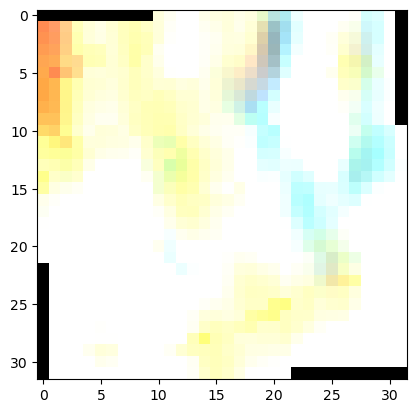

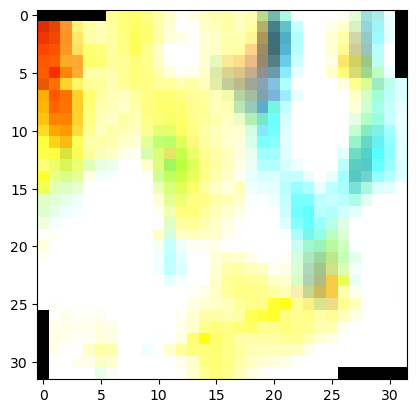

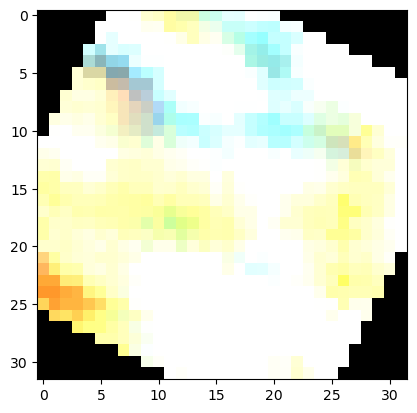

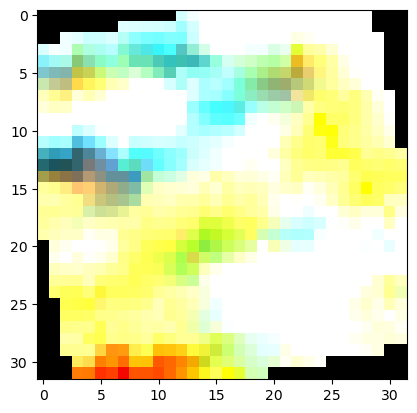

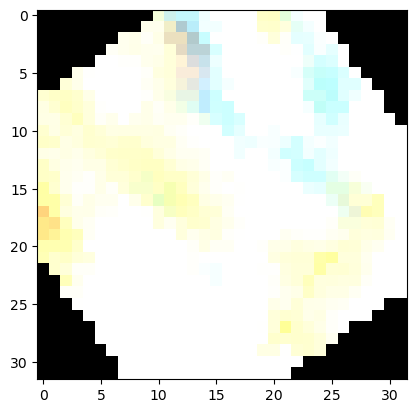

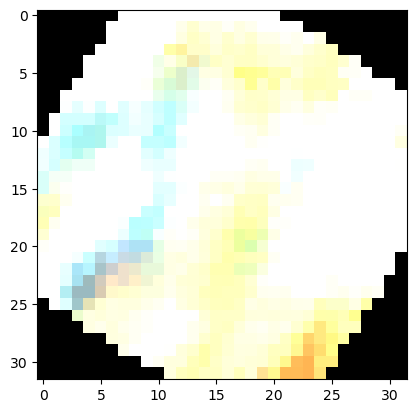

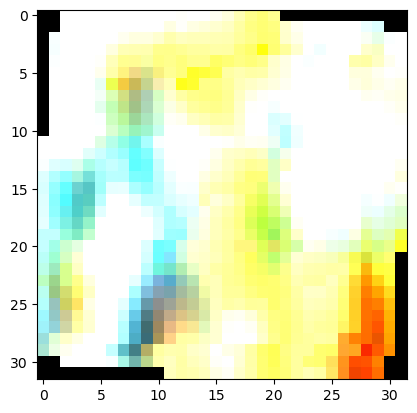

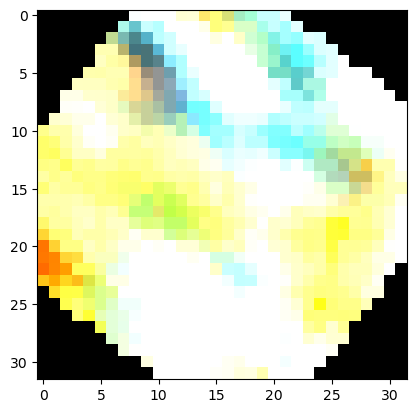

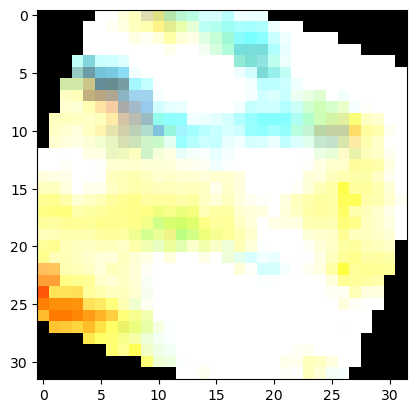

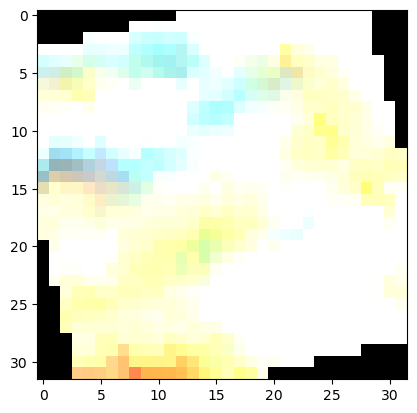

21054

In [23]:
x = SlicedDataset('1', 'train', do_augment=True)
for i in range(3):
    im, lbl, _ = x[len(x) // 2]
    plt.imshow(np.transpose(im, (1, 2, 0)))
    plt.imshow(np.transpose(lbl, (1, 2, 0)))
    plt.show()
del x
gc.collect()

Model definition

In [24]:
fcn_model = torch.load(MODEL_PATH)
fcn_model = fcn_model
# fcn_model.backbone.conv1 = torch.nn.Conv2d(
#     Z_DIM, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
fcn_model.classifier[4] = torch.nn.Conv2d(512, 1, kernel_size=(1, 1), stride=(1, 1))

fcn_model = fcn_model.to(DEVICE)

Freeze backbone, then unfreeze backbone.conv1

In [ ]:
# for param in fcn_model.backbone.parameters():
#   param.requires_grad = False

# for param in fcn_model.backbone.conv1.parameters():
#   param.requires_grad = True

Train on fragments 1 and 2

In [29]:
fcn_model.train()

def train_on_fragment(fragment_name, ds):
    dl = torch.utils.data.DataLoader(ds, batch_size=BSIZE, shuffle=True)
    class WeightedBCELoss(torch.nn.Module):
      def __init__(self):
          super().__init__()

      def forward(self, pred, actual):
          weights = torch.ones(actual.shape).to(DEVICE)
          weights[torch.where(actual == 1.)] = 3.
          return torch.nn.BCELoss(weights)(pred, actual)

    criterion = WeightedBCELoss()
    optimizer = torch.optim.Adam(fcn_model.parameters(), lr=LR)

    losses = []
    fbetas = []
    precisions = []
    recalls = []
    gradnorms = []
    predsnorms = []
    livegen = np.zeros(ds.surface.shape[1:])

    def gradnorm():
        grads = [
            param.grad.detach().flatten()
            for param in fcn_model.parameters()
            if param.grad is not None
        ]
        norm = torch.cat(grads).norm().cpu()
        return norm

    def plot():
        fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(15, 3))
        fig.suptitle(f'Training on {fragment_name}')
        axs[0].plot(gaussian_filter1d(losses, sigma=25), label='loss')
        axs[0].plot(gaussian_filter1d(precisions, sigma=25), label='precisions')
        axs[0].plot(gaussian_filter1d(recalls, sigma=25), label='recalls')
        axs[0].plot(gaussian_filter1d(fbetas, sigma=25), label='fbetas')
        axs[1].plot(gaussian_filter1d(gradnorms, sigma=25), label='gradnorms')
        axs[2].plot(gaussian_filter1d(predsnorms, sigma=25), label='predsnorms')
        axs[3].imshow(livegen)
        axs[0].legend()
        axs[1].legend()
        axs[2].legend()
        plt.savefig(f'/kaggle/working/training_{fragment_name}_{datetime.datetime.now().strftime("%d-%m-%H:%M:%S")}.png')
        plt.show()

    for i, (surface, inklabels, (ys, xs)) in enumerate(pbar := tqdm(dl, disable=TQDM_OFF)):
        if i > MAX_STEPS:
            break
        optimizer.zero_grad()

        preds = torch.sigmoid(fcn_model(surface.to(DEVICE))['out'])
        pred_ink = preds.detach().gt(0.5).cpu().int()
        loss = criterion(preds, inklabels.to(DEVICE))
        loss.backward()
        optimizer.step()

        # TODO: vectorize
        for j in range(BSIZE):
          livegen[ys[j]:ys[j] + YX_DIM, xs[j]:xs[j] + YX_DIM] = preds[j, 0].detach().cpu().numpy()

        fbeta = fbeta_score(inklabels.view(-1).numpy(), pred_ink.view(-1).numpy(), beta=0.5)
        precision = precision_score(inklabels.view(-1).numpy(), pred_ink.view(-1).numpy())
        recall = recall_score(inklabels.view(-1).numpy(), pred_ink.view(-1).numpy())

        fbetas.append(fbeta)
        losses.append(loss.detach().cpu().float())
        precisions.append(precision)
        recalls.append(recall)
        gradnorms.append(gradnorm())
        predsnorms.append(preds.detach().norm().cpu())

        pbar.set_postfix({
            "loss": loss,
            "prec": precision,
            "rec": recall,
            "fbeta": fbeta,
            "gradnorm": gradnorms[-1],
            "predsnorm": predsnorms[-1]})

        if i % PLOT_EVERY == PLOT_EVERY - 1:
            plot()

    plot()

    # Cleanup
    del ds
    del dl
    del livegen
    torch.save(fcn_model, f'/kaggle/working/model_{datetime.datetime.now().strftime("%d-%m-%H:%M:%S")}')

train_on_fragment('2', SlicedDataset('2', 'train', max_shape=(6000, 6000), do_augment=True))
gc.collect()
train_on_fragment('1', SlicedDataset('1', 'train', do_augment=True))
gc.collect()

Loading surface


  0%|          | 0/3 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/PIL/Image.py:3176: DecompressionBombWarning: Image size (140973980 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


After normalizing surface: mean: -2.7563541493691446e-07 stdev: 0.9999977350234985
After normalizing surface: mean: 2.466171622472757e-07 stdev: 0.9999934434890747
After normalizing surface: mean: -4.926246788272692e-07 stdev: 1.000001072883606
Loading mask train/2
Loading inklabels train/2


  0%|          | 0/139129 [00:00<?, ?it/s]

KeyboardInterrupt: 

Define a function to generate the image

In [ ]:
def generate_raw_prediction(dataset):
    out = np.zeros(dataset.surface.shape[1:])
    # TODO: handle borders better
    for y in tqdm(range(0, dataset.surface.shape[1] - YX_DIM, YX_DIM), disable=TQDM_OFF):
        for x in range(0, dataset.surface.shape[2] - YX_DIM, YX_DIM):
            surface, _, _ = dataset.getitem(y, x)
            surface = torch.Tensor(np.expand_dims(surface, axis=0)).to(DEVICE)
            preds = torch.sigmoid(fcn_model(torch.Tensor(surface).to(DEVICE))['out'])
            out[y:y + YX_DIM, x:x + YX_DIM] = preds[0].detach().cpu().numpy()
    out *= dataset.mask
    return out


def apply_thr(raw, thr):
    out = np.copy(raw)
    out[np.where(out < thr)] = 0.
    out[np.where(out >= thr)] = 1.
    return out

Validate on fragment 3. Dipslay predicted image.

In [ ]:
%%time

fcn_model.eval()

def update_threshold():
    global TH
    thresholds = np.arange(0.1, 1.0, 0.07)
    ds = SlicedDataset('3', 'train')
    raw = generate_raw_prediction(ds)
    plt.imshow(raw)
    plt.show()

    best_fbeta = 0.0
    for thr in thresholds:
        out = apply_thr(raw, thr)
        fbeta = fbeta_score(ds.inklabels.flatten().astype(int), out.flatten().astype(int), beta=0.5)
        precision = precision_score(ds.inklabels.flatten().astype(int), out.flatten().astype(int))
        recall = recall_score(ds.inklabels.flatten().astype(int), out.flatten().astype(int))

        print(f"thr: {thr} fbeta: {fbeta} precision: {precision} recall: {recall}")

        if fbeta > best_fbeta:
            best_fbeta = fbeta
            TH = thr

update_threshold()


gc.collect()

Test output serialization on train data

In [ ]:
def rle(preds):
    preds = preds.flatten()
    starts = 2 + np.array(np.where(preds[1:] - preds[:-1] == 1.)).flatten()
    ends = 2 + np.array(np.where(preds[1:] - preds[:-1] == -1.)).flatten()
    return np.stack([starts, ends - starts], axis=1)

def serialize_rle(rle):
    return ' '.join(f"{x[0]} {x[1]}" for x in rle)

In [ ]:
ds = SlicedDataset('3', 'train')
print(serialize_rle(rle(ds.inklabels)))
!cat /kaggle/input/vesuvius-challenge-ink-detection/train/3/inklabels_rle.csv

One more training round, on fragment '3'

In [ ]:
fcn_model.train()

train_on_fragment('3', ds)
gc.collect()

fcn_model.eval()

Generate test predictions

In [ ]:
submission = defaultdict(list)

for fragment_name in os.listdir('/kaggle/input/vesuvius-challenge-ink-detection/test/'):
    ds = SlicedDataset(fragment_name, 'test')
    out = apply_thr(generate_raw_prediction(ds), TH)

    submission["Id"].append(fragment_name)
    submission["Predicted"].append(serialize_rle(rle(out)))

pd.DataFrame.from_dict(submission).to_csv("/kaggle/working/submission.csv", index=False)

In [ ]:
pd.DataFrame.from_dict(submission)

In [ ]:
!cut -c-100 /kaggle/working/submission.csv